
For this project, I am going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.


First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
#tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.



The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [37]:
data = pd.read_csv("data.csv", names = column_names)
data.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157




It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [38]:
data.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64


We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [39]:
df = data.iloc[:,1:]
df_normalized = (df - df.mean())/df.std()
df_normalized.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


In [40]:
df_normalized.describe()

,date,age,distance,stores,latitude,longitude,price
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,-1.116383e-14,3.765876e-17,-6.514789e-17,-1.620926e-17,-7.352341e-16,-2.087108e-15,-2.451372e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.633106e+00,-1.672178e+00,-1.555642e+00,-1.563848e+00,-1.572238e+00,-1.576456e+00,-2.589835e+00
25%,-9.001796e-01,-8.777939e-01,-9.306100e-01,-9.274906e-01,-9.397246e-01,-9.451413e-01,-6.944613e-01
50%,1.597778e-02,4.854567e-03,6.937854e-03,2.704518e-02,9.044936e-03,1.830813e-03,-1.287120e-02
75%,9.321352e-01,8.875030e-01,9.444857e-01,9.815810e-01,9.578145e-01,9.488029e-01,6.929651e-01
max,1.665061e+00,1.681887e+00,1.569518e+00,1.617938e+00,1.590328e+00,1.580118e+00,2.995138e+00


Equal Standard deviation of all the columns shows our data is properly normalized.

###  Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [0]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_values (pred):
  return int(pred * y_std + y_mean)

In [42]:
#testing_function
print(convert_label_values(0.350088))

14263


  14263 =~ 14264
  Hence we say our function works good enough!

(=~ means almost/nearly equal to)

### Create Training and Test Sets

### Select Features


In [0]:
X = df_normalized.iloc[:,:6].values
y = df_normalized.iloc[:,6].values

### Checking shapes

In [20]:
print("The shape of features array is", X.shape)
print("The shape of labels array is", y.shape)

The shape of features array is (5000, 6)
The shape of labels array is (5000,)


### Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

print("The shape of the Training set: ", x_train.shape, y_train.shape)
print("The shape of the Test set: ", x_test.shape, y_test.shape)

The shape of the Training set:  (4500, 6) (4500,)
The shape of the Test set:  (500, 6) (500,)


# Create the Model

### Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [45]:
def get_model():
  model = Sequential([
                 Dense(10, input_shape = (6,), activation = 'relu'),
                 Dense(20, activation = 'relu'),
                 Dense(5, activation = 'relu'),  
                 Dense(1)
           ])
  model.compile(loss='mse', optimizer = 'adam', )
  return model

get_model().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                70        
_________________________________________________________________
dense_17 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


#Model Training



We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [46]:
es_cb = EarlyStopping(monitor='val_loss', patience=5)
model = get_model()
preds_on_untrained = model.predict(x_test)

history = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 100, 
    callbacks = [es_cb]
)

Epoch 1/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5343 - val_loss: 0.2614
Epoch 2/100
141/141 [==============================] - 0s 1ms/step - loss: 0.2168 - val_loss: 0.1987
Epoch 3/100
141/141 [==============================] - 0s 2ms/step - loss: 0.1858 - val_loss: 0.1783
Epoch 4/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1743 - val_loss: 0.1725
Epoch 5/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1695 - val_loss: 0.1692
Epoch 6/100
141/141 [==============================] - 0s 2ms/step - loss: 0.1656 - val_loss: 0.1676
Epoch 7/100
141/141 [==============================] - 0s 2ms/step - loss: 0.1628 - val_loss: 0.1637
Epoch 8/100
141/141 [==============================] - 0s 2ms/step - loss: 0.1610 - val_loss: 0.1596
Epoch 9/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1600 - val_loss: 0.1628
Epoch 10/100
141/141 [==============================] - 0s 1ms/step - loss: 0.1593 - val_lo

###Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

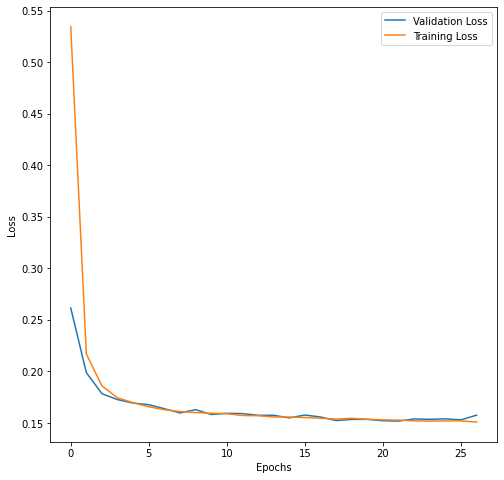

In [47]:
plot_loss(history)

We can observe our model is perfproming really well. It has minimized the loss fuction perfectly.

# Predictions

##  Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

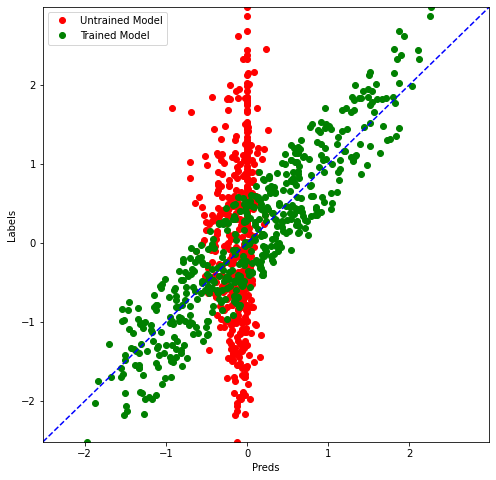

In [48]:
preds_on_trained_model = model.predict(x_test)
compare_predictions(preds_on_untrained, preds_on_trained_model, y_test)

The linear pattern of predicted model is clearly visible in green color, while the red color depicts the random predictions by untrained model.

##  Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

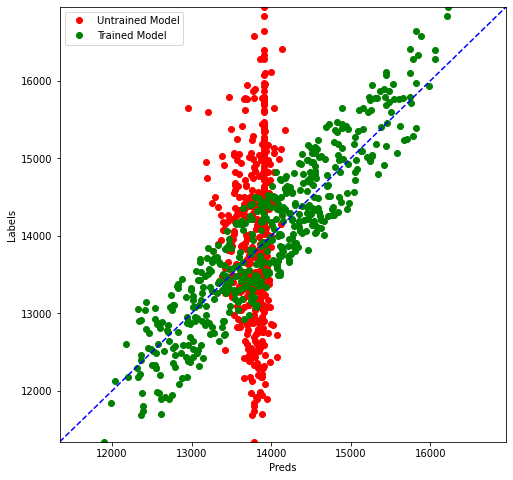

In [49]:
untrained_predicted_price = [convert_label_values(y) for y in preds_on_untrained]
predicted_price = [convert_label_values(y) for y in preds_on_trained_model]
price_test = [convert_label_values(y) for y in y_test]

compare_predictions(untrained_predicted_price, predicted_price, price_test)

## Date Completed: 3rd June 2020
### By Atharva Jibhakate
[Click here](https://colab.research.google.com/drive/1o1fWjtkUU6kghRBgh80Y2Str4DvrFsqZ?usp=sharing) to see this notebook in Google Colab.